**Importing Dependencies**

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Importing Dataset**


In [2]:
# Importing the dataset
dataset = pd.read_csv('/content/Sentiment140.tsv', sep='\t')

In [3]:
# Check for null values
dataset.isnull().values.any()

False

In [4]:
# Check shape of date
dataset.shape

(160000, 2)

In [5]:
dataset

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6


**Data Visualization**

In [6]:
# Decoding label (0 or 4) to sentiment (Negative or Positive)
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
dataset.sentiment_label = dataset.sentiment_label.apply(lambda x: label_decoder(x))
dataset.head()

,sentiment_label,tweet_text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...


[Text(0.5, 1.0, 'Distribution of Sentiment Data')]

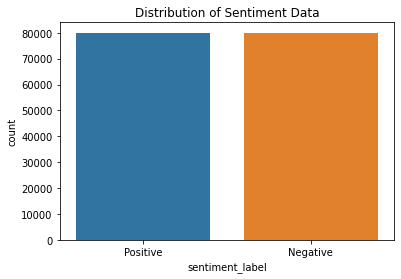

In [7]:
# Visualize the balance of the dataset
import seaborn as sns

sns.countplot(x='sentiment_label', data=dataset).set(title='Distribution of Sentiment Data')

In [8]:
# Randomized visualization of the data
import random

random_idx_list = [random.randint(1,len(dataset.tweet_text)) for i in range(10)] # creates random indexes to choose from dataframe
dataset.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment_label,tweet_text
131708,Positive,@Monkiimagic I think it's cos I'd had my aller...
93024,Positive,Just got here
132938,Positive,"&quot;tagged as: punk, punk rock, pop punk, ne..."
141738,Negative,i cant stop being sad
75113,Negative,is pumped and bummed all at the same time.......
20515,Negative,@DaniAlexLuna hey u! how r things? i've been g...
10156,Negative,Locked myself out of the house
16892,Positive,"just went to a bridal shower, saw a stripper, ..."
74528,Positive,says thanks http://www.plurk.com/eyminep http...
105576,Negative,dammit only made string orchestra!! how depres...


In [9]:
# Storing data in lists.
text, sentiment = list(dataset['tweet_text']), list(dataset['sentiment_label'])

In [10]:
len(text)

160000

**Tweet Text Preprocessing**


In [11]:
# Defining the stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [13]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' ',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, " " + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' ', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [14]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 34 seconds


In [15]:
processedtext

['hey dear happy friday to you already had your rice bowl for lunch ',
 'ughh layin downn waiting for zeina to cook breakfast ',
 'reckon he ll play even if he not 100 but know nothing wink it won be the same without him ',
 'know saw it on the news ',
 'very sad that ha closed down one of the few web service that ve used for over year ',
 'who sings remember alwayss hear it on radio but never catch the artist ',
 'with god on ur side anything is possible ',
 'why being stupid ',
 'having delved back into the gut of expression engine it flexible cm if you have to use it a dev not great for client though ',
 'aww take him with you ',
 'the video on vh1 is much better than the tube one ',
 'ran out of champagne wonder if call my brother could convince him to bring me up bottle ',
 'wish wa going to the show tonight ',
 'doing homework then bed waking up at is gonna be awful ',
 'ashleyltmsyf hey ashley when will the hush hush hush hush video be out can wait ',
 'scratch that enjoy seein 

In [16]:
dataset

,sentiment_label,tweet_text
0,Positive,"@elephantbird Hey dear, Happy Friday to You A..."
1,Positive,Ughhh layin downnnn Waiting for zeina to co...
2,Negative,"@greeniebach I reckon he'll play, even if he's..."
3,Negative,@vaLewee I know! Saw it on the news!
4,Negative,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,Negative,STILL @ panera...studying for &quot;mock&quot;...
159996,Negative,Insomnia is out of control tonight--haven't sl...
159997,Positive,@Covergirl08 I take pride in what I do
159998,Positive,heading to work on the 6


In [17]:
# Add Processed tweets as a new column to the dataset
dataset['processed_tweet'] = processedtext

In [18]:
dataset

,sentiment_label,tweet_text,processed_tweet
0,Positive,"@elephantbird Hey dear, Happy Friday to You A...",hey dear happy friday to you already had your ...
1,Positive,Ughhh layin downnnn Waiting for zeina to co...,ughh layin downn waiting for zeina to cook bre...
2,Negative,"@greeniebach I reckon he'll play, even if he's...",reckon he ll play even if he not 100 but know ...
3,Negative,@vaLewee I know! Saw it on the news!,know saw it on the news
4,Negative,very sad that http://www.fabchannel.com/ has c...,very sad that ha closed down one of the few we...
...,...,...,...
159995,Negative,STILL @ panera...studying for &quot;mock&quot;...,still panera studying for quot mock quot board...
159996,Negative,Insomnia is out of control tonight--haven't sl...,insomnia is out of control tonight haven slept...
159997,Positive,@Covergirl08 I take pride in what I do,take pride in what do
159998,Positive,heading to work on the 6,heading to work on the


In [19]:
# Randomized visualization of the new data
import random

random_idx_list = [random.randint(1,len(dataset.processed_tweet)) for i in range(10)] # creates random indexes to choose from dataframe
dataset.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment_label,tweet_text,processed_tweet
83551,Positive,@spurofmoment,
5481,Positive,@MiklBarton seriously! ask @sealabcore he got ...,seriously ask he got bunch of book on iphone d...
58517,Negative,@callum11 ok LOL just needing more,ok lol just needing more
134790,Negative,seriously considering coloring my hair...SOO m...,seriously considering coloring my hair soo man...
142249,Negative,Guess I should hit the sack. Sigh. Hullo bad d...,guess should hit the sack sigh hullo bad dream
106805,Negative,Damn ASPCA Commercials!!! Stop making me all sad,damn aspca commercial stop making me all sad
117779,Positive,relaxing after a hard shopping day,relaxing after hard shopping day
43500,Positive,Can't believe I have to work on Free Comic Boo...,can believe have to work on free comic book da...
119576,Positive,As Illeana tends to barrage people she works w...,a illeana tends to barrage people she work wit...
147904,Positive,@Superrdouche LOL Of course not! Why would tha...,lol of course not why would that make me vote ...


**Data Analysis**


**Word-Cloud for Positive tweets.**

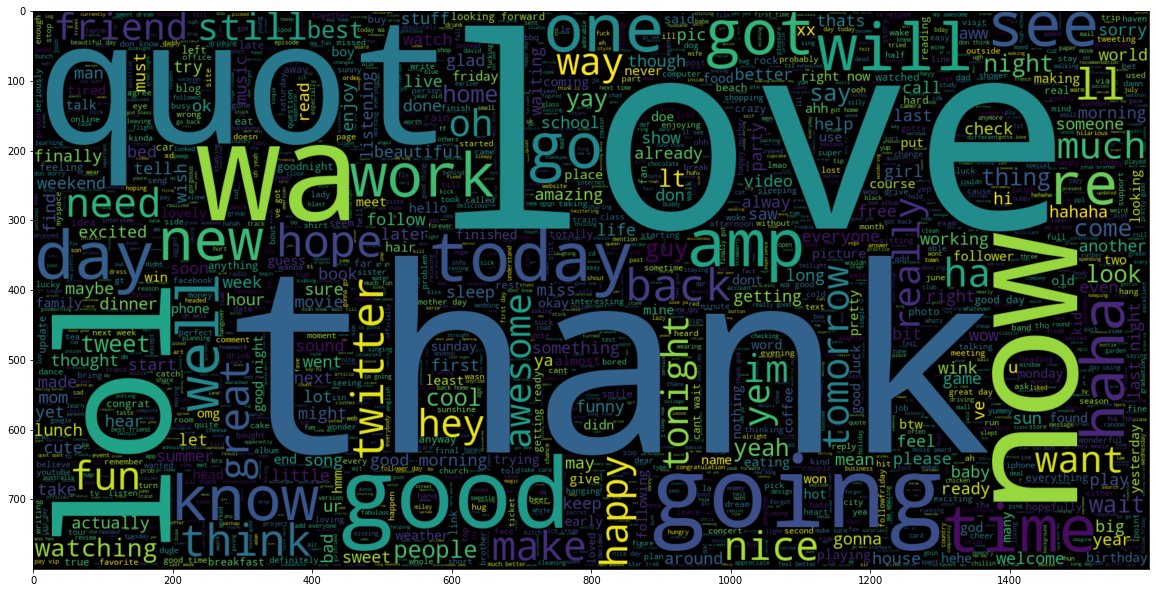

In [20]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataset[dataset.sentiment_label == 'Positive'].processed_tweet))
plt.imshow(wc , interpolation = 'bilinear')

**Word-Cloud for Negative tweets.**

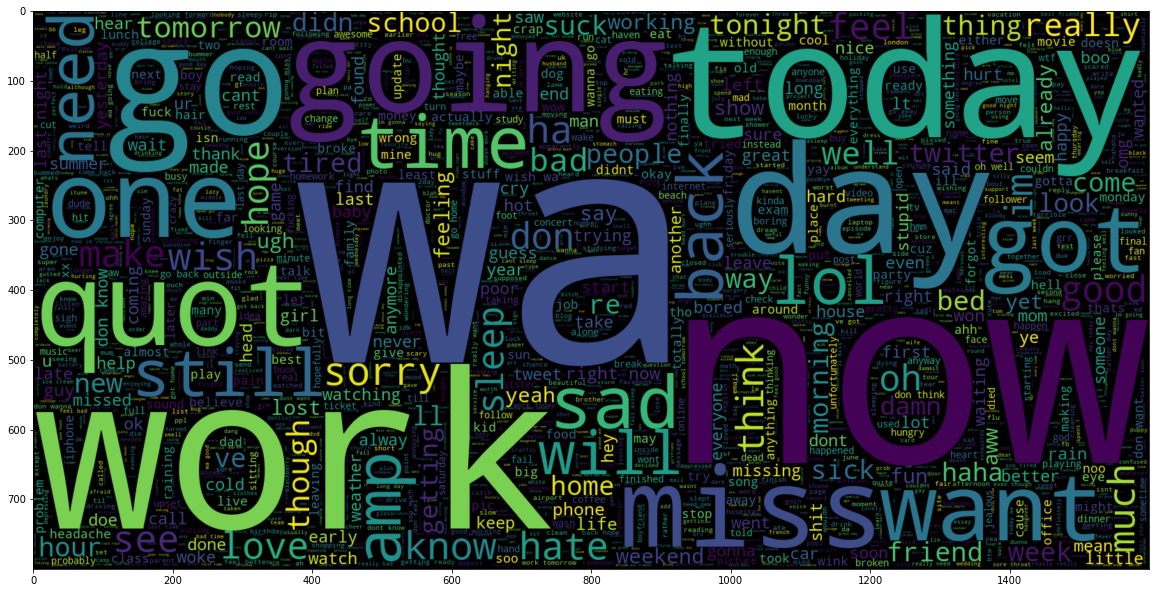

In [21]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataset[dataset.sentiment_label == 'Negative'].processed_tweet))
plt.imshow(wc , interpolation = 'bilinear')

**Splitting Data**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataset.processed_tweet, dataset.sentiment_label,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


**Vectorizing**

In [23]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


**Data Transformation**

In [24]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


**Creating and Evaluating Models**

We're creating 4 different types of model for our sentiment analysis problem:  
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**
* **Random Forest (RF)**


**Evaluate Model Function**

In [25]:
# Storage arrays for visualization
ACCURACIES = []
TIME = []

In [26]:
from sklearn.metrics import accuracy_score
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    ACCURACIES.append(round(accuracy_score(y_test, model.predict(X_test)), 2))
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)




### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

    Negative       0.81      0.77      0.79      4061
    Positive       0.77      0.81      0.79      3939

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000

Model Training Complete.
Time Taken: 2 seconds


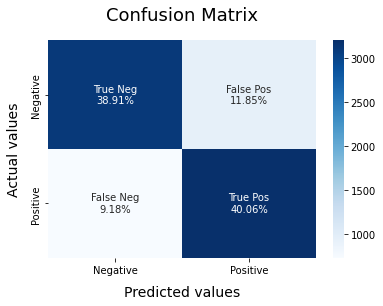

In [27]:
t = time.time()
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
print(f'Model Training Complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
TIME.append(round(time.time()-t))

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80      4061
    Positive       0.80      0.79      0.79      3939

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

Model Training Complete.
Time Taken: 4 seconds


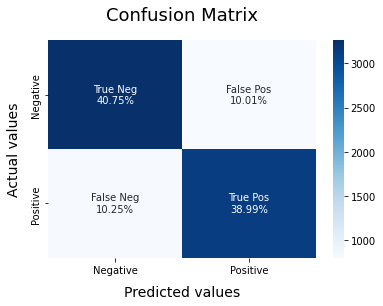

In [28]:
t = time.time()
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
print(f'Model Training Complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
TIME.append(round(time.time()-t))

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      4061
    Positive       0.80      0.80      0.80      3939

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

Model Training Complete.
Time Taken: 39 seconds


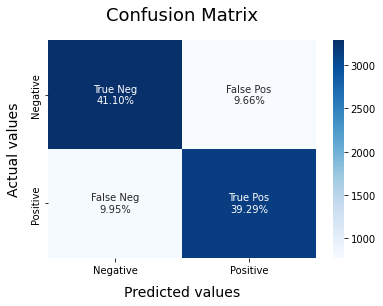

In [29]:
t = time.time()
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
print(f'Model Training Complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
TIME.append(round(time.time()-t))

### <a name="p8-3">Random Forest Model</a>

N.B: This cell of the notebook runs Random Forest, which takes about 20 minutes to completely finish. If you want to run, uncomment this cell, and the cell of the visualization that includes Random Forest. 

              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78      4061
    Positive       0.78      0.73      0.76      3939

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000

Model Training Complete.
Time Taken: 1286 seconds


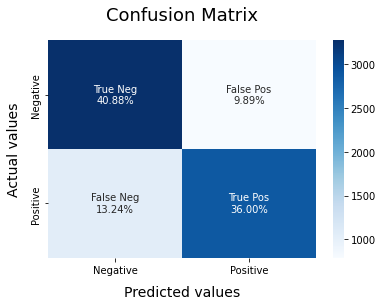

In [30]:
"""  
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import cross_val_score

  t = time.time()
  RFmodel = RandomForestClassifier(n_estimators=20)
  RFmodel.fit(X_train, y_train)
  model_Evaluate(RFmodel)
  print(f'Model Training Complete.')
  print(f'Time Taken: {round(time.time()-t)} seconds')
  TIME.append(round(time.time()-t))
"""

In [31]:
ACCURACIES

[0.79, 0.8, 0.8, 0.77]

In [32]:
TIME

[2, 4, 39, 1286]

**Performance Visualization**

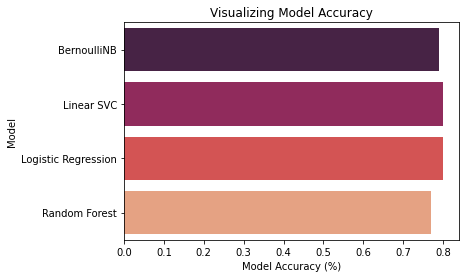

In [33]:
classifier_names = ['BernoulliNB', 'Linear SVC', 'Logistic Regression', 'Random Forest']
# Creating a bar plot
sns.barplot(x=ACCURACIES, y=classifier_names, palette= 'rocket')
# Add labels to your graph
plt.xlabel('Model Accuracy (%)')
plt.ylabel('Model')
plt.title("Visualizing Model Accuracy")
plt.show()

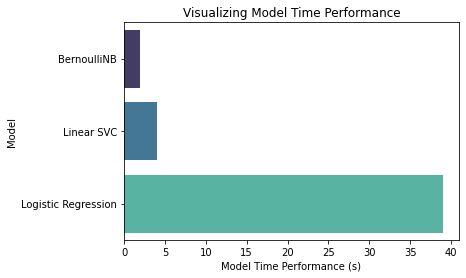

In [34]:
classifier_names = ['BernoulliNB', 'Linear SVC', 'Logistic Regression']
# Creating a bar plot
sns.barplot(x=TIME[:3], y=classifier_names, palette= 'mako')
# Add labels to your graph
plt.xlabel('Model Time Performance (s)')
plt.ylabel('Model')
plt.title("Visualizing Model Time Performance")
plt.show()

N.B: This visualization works only if you run Random Forest. 

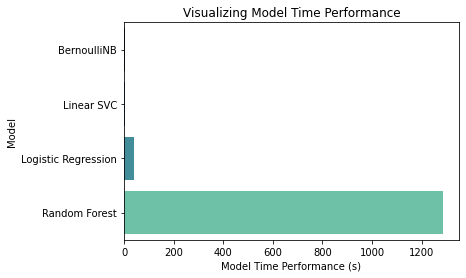

In [35]:
"""
  classifier_names = ['BernoulliNB', 'Linear SVC', 'Logistic Regression', 'Random Forest']
  # Creating a bar plot
  sns.barplot(x=TIME, y=classifier_names, palette= 'mako')
  # Add labels to your graph
  plt.xlabel('Model Time Performance (s)')
  plt.ylabel('Model')
  plt.title("Visualizing Model Time Performance")
  plt.show()
"""

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser and BernoulliNB, Logistic Regression Model** for later use.

In [36]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

"""
file = open('Sentiment-RF.pickle','wb')
pickle.dump(RFmodel, file)
file.close()
"""

## <a name="p10">Using the Model.</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [42]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    
    # Text to classify should be in a list.
    text = ["May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "This is why people admire you.",
            "I don't think you are as good as you think you are.",
            "Cows lose their jobs as milk prices drop"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                text sentiment
0                         May the Force be with you.  Positive
1                    Mr. Stark, I don't feel so good  Negative
2                     This is why people admire you.  Positive
3  I don't think you are as good as you think you...  Positive
4           Cows lose their jobs as milk prices drop  Negative
